In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
# 1. 数据预处理和加载

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 随机裁剪
    transforms.RandomHorizontalFlip(),     # 随机水平翻转
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),  # 标准化
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class Bottle2neckX(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, baseWidth, cardinality, stride=1, downsample=None, scale = 4, stype='normal'):
 
        super(Bottle2neckX, self).__init__()

        D = int(math.floor(planes * (baseWidth/64.0)))
        C = cardinality

        self.conv1 = nn.Conv2d(inplanes, D*C*scale, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(D*C*scale)

        if scale == 1:
          self.nums = 1
        else:
          self.nums = scale -1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride = stride, padding=1)
        convs = []
        bns = []
        for i in range(self.nums):
          convs.append(nn.Conv2d(D*C, D*C, kernel_size=3, stride = stride, padding=1, groups=C, bias=False))
          bns.append(nn.BatchNorm2d(D*C))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(D*C*scale, planes * 4, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.width  = D*C
        self.stype = stype
        self.scale = scale

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
          if i==0 or self.stype=='stage':
            sp = spx[i]
          else:
            sp = sp + spx[i]
          sp = self.convs[i](sp)
          sp = self.relu(self.bns[i](sp))
          if i==0:
            out = sp
          else:
            out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype=='normal':
          out = torch.cat((out, spx[self.nums]),1)
        elif self.scale != 1 and self.stype=='stage':
          out = torch.cat((out, self.pool(spx[self.nums])),1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Res2NeXt(nn.Module):
    def __init__(self, block, baseWidth, cardinality, layers, num_classes, scale=4):

        super(Res2NeXt, self).__init__()

        self.cardinality = cardinality
        self.baseWidth = baseWidth
        self.num_classes = num_classes
        self.inplanes = 64
        self.output_size = 64
        self.scale = scale

        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], 2)
        self.layer3 = self._make_layer(block, 256, layers[2], 2)
        self.layer4 = self._make_layer(block, 512, layers[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)  
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, self.baseWidth, self.cardinality, stride, downsample, scale=self.scale, stype='stage'))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, self.baseWidth, self.cardinality, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
def res2next50(pretrained=False, **kwargs):
    model = Res2NeXt(Bottle2neckX, layers = [3, 3, 3, 3], baseWidth = 24, cardinality=6, scale = 4, num_classes=100)
    return model

In [12]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = res2next50()

pretrained_dict = torch.load('res2next50.pth', map_location=torch.device('cpu'))
model_dict = model.state_dict()

# 逐层加载权重，忽略尺寸不匹配的层
for name, param in pretrained_dict.items():
    if name in model_dict and model_dict[name].shape == param.shape:
        model_dict[name].copy_(param)
    else:
        print(f'Skip loading parameter {name}, shape mismatch: {model_dict[name].shape} vs {param.shape}')

model.load_state_dict(model_dict)






cpu
Skip loading parameter layer1.0.conv1.weight, shape mismatch: torch.Size([576, 64, 1, 1]) vs torch.Size([128, 64, 1, 1])
Skip loading parameter layer1.0.bn1.weight, shape mismatch: torch.Size([576]) vs torch.Size([128])
Skip loading parameter layer1.0.bn1.bias, shape mismatch: torch.Size([576]) vs torch.Size([128])
Skip loading parameter layer1.0.bn1.running_mean, shape mismatch: torch.Size([576]) vs torch.Size([128])
Skip loading parameter layer1.0.bn1.running_var, shape mismatch: torch.Size([576]) vs torch.Size([128])
Skip loading parameter layer1.0.convs.0.weight, shape mismatch: torch.Size([144, 24, 3, 3]) vs torch.Size([32, 4, 3, 3])
Skip loading parameter layer1.0.convs.1.weight, shape mismatch: torch.Size([144, 24, 3, 3]) vs torch.Size([32, 4, 3, 3])
Skip loading parameter layer1.0.convs.2.weight, shape mismatch: torch.Size([144, 24, 3, 3]) vs torch.Size([32, 4, 3, 3])
Skip loading parameter layer1.0.bns.0.weight, shape mismatch: torch.Size([144]) vs torch.Size([32])
Skip lo

KeyError: 'layer2.3.conv1.weight'

In [ ]:
def train_and_evaluate(model, trainloader, testloader, num_epochs=10):

    best_test_acc = 0.0
    epochs_since_improvement = 0
    early_stopping_patience = 20
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        test_accuracies.append(test_acc)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1
            if epochs_since_improvement == early_stopping_patience:
                print(f"早停机制触发，在第 {epoch+1} 轮停止训练。")
                break
        scheduler.step()
     # 绘制损失和准确度曲线
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # 绘制训练损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制训练和测试准确度曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, test_accuracies, 'r', label='Test accuracy')
    plt.title('Training and Test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Epoch [1/100], Loss: 5.6503, Train Accuracy: 1.74%, Test Accuracy: 2.89%
Epoch [2/100], Loss: 4.2464, Train Accuracy: 4.72%, Test Accuracy: 7.52%
Epoch [3/100], Loss: 4.0171, Train Accuracy: 7.62%, Test Accuracy: 10.03%
Epoch [4/100], Loss: 3.8648, Train Accuracy: 9.92%, Test Accuracy: 11.06%
Epoch [5/100], Loss: 3.7493, Train Accuracy: 11.69%, Test Accuracy: 14.32%
Epoch [6/100], Loss: 3.6290, Train Accuracy: 13.43%, Test Accuracy: 17.12%
Epoch [7/100], Loss: 3.5166, Train Accuracy: 15.56%, Test Accuracy: 18.87%
Epoch [8/100], Loss: 3.3995, Train Accuracy: 17.70%, Test Accuracy: 20.79%
Epoch [9/100], Loss: 3.3093, Train Accuracy: 19.26%, Test Accuracy: 21.61%
Epoch [10/100], Loss: 3.2359, Train Accuracy: 20.61%, Test Accuracy: 23.05%
Epoch [11/100], Loss: 3.1634, Train Accuracy: 21.99%, Test Accuracy: 23.93%
Epoch [12/100], Loss: 3.0757, Train Accuracy: 23.54%, Test Accuracy: 24.99%
Epoch [13/100], Loss: 3.0168, Train Accuracy: 24.88%, Test Accuracy: 24.23%
Epoch [14/100], Loss: 2.968

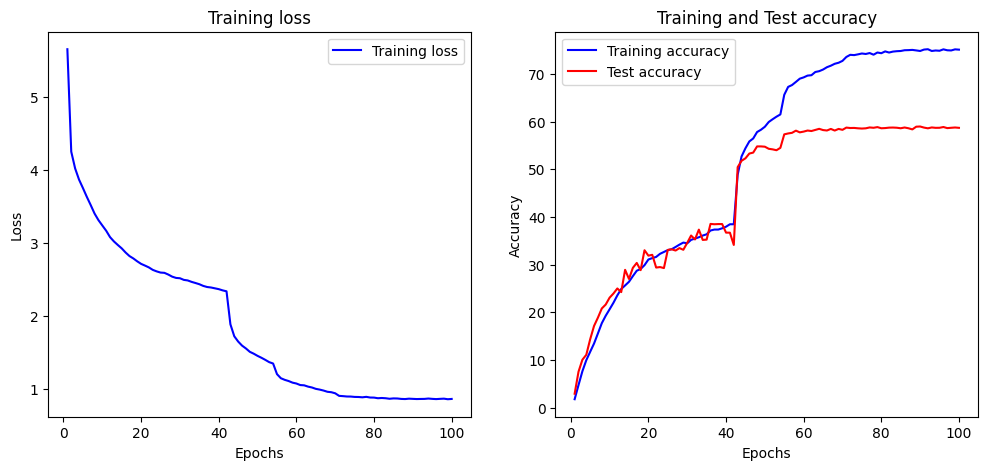

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
# 定义学习率调度器
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_and_evaluate(model, trainloader, testloader, num_epochs=100)